## Análise de Resultados

In [8]:
import sys, os
import plotly.graph_objects as go
import numpy as np

sys.path.insert(0, "/media/workspace/DeepFood/deep-reco-gym/tools/eval_viz")
import pandas as pd
import argparse
import copy
import numpy as np
import os
import random
import json
from pandas.io.json import json_normalize
from app import fetch_iteraction_results_path, load_all_iteraction_metrics
from app import load_iteractions_params as load_iteractions_params2, PATH_EVAL_REINFORCEMENT
from plot import plot_line_iteraction, plot_exploration_arm, get_colors
import pandas as pd
import argparse
import copy
import numpy as np
import streamlit as st

#sys.path.insert(0, os.path.dirname(__file__))


In [9]:
models_and_legend = {
  "____random_":           ["bandit_policy", "observation"],
  "____fixed_":            ["bandit_policy", "observation"],
  "____lin_ucb_":          ["bandit_policy", "bandit_policy_params.alpha", "full_refit", "val_split_type"],
  "____model_":            ["bandit_policy","full_refit", "val_split_type"],
  "____custom_lin_ucb_":   ["bandit_policy", "bandit_policy_params.alpha", "full_refit", "val_split_type"],
  "____epsilon_greedy_":   ["bandit_policy","bandit_policy_params.epsilon", "full_refit", "val_split_type"],
  "____softmax_":          ["bandit_policy","bandit_policy_params.logit_multiplier", "full_refit", "val_split_type"],
  "____lin_ts_":           ["bandit_policy","bandit_policy_params.v_sq", "full_refit", "val_split_type"],
  "____percentile_adapt_":       ["bandit_policy","bandit_policy_params.exploration_threshold", "full_refit", "val_split_type"],
  "____adaptive_":         ["bandit_policy","bandit_policy_params.exploration_threshold", "bandit_policy_params.decay_rate", "full_refit", "val_split_type"],  
  "____explore_then_exp_": ["bandit_policy","bandit_policy_params.explore_rounds", "bandit_policy_params.decay_rate", "full_refit", "val_split_type"],    
}

path = PATH_EVAL_REINFORCEMENT

In [10]:
def list_paths_per_model(input_path):
    models = []
    
    for model, legend in models_and_legend.items():
    #print(model)
    #print(legend)
        for root, dirs, files in os.walk(input_path):
            if '/results' in root and 'Interaction' in root:
                for d in dirs:
                    #print(os.path.join(root, d))
                    if model in d:
                        models.append(os.path.join(root, d))
    return models

def load_iteractions_params(iteractions):
  if len(iteractions) == 0:
    return pd.DataFrame()

  dfs = []

  for model in iteractions:

    file_path = os.path.join(model, 'params.json')
    data      = []

    #try:
    with open(file_path) as json_file:
        d = json.load(json_file)
        data.append(d)

        df = pd.DataFrame.from_dict(json_normalize(data), orient='columns')
      
    #except:
    #  df = pd.DataFrame()

    df['iteraction'] = model
    dfs.append(df)
  
  return pd.concat(dfs)


def load_data_iteractions_metrics(path, sample_size = 10000):
    random.seed(42)
    file      = os.path.join(path,'sim-datalog.csv')

    # Count the lines
    num_lines = sum(1 for l in open(file)) - 1

    # Sample size - in this case ~10%
    size = np.min([sample_size, num_lines])#int(num_lines / 10)

    # The row indices to skip - make sure 0 is not included to keep the header!
    skip_idx  = sorted(random.sample(range(1, num_lines), num_lines - size))
    idx       = list(set(list(range(num_lines))) - set(skip_idx))

    df        = pd.read_csv(file, skiprows=skip_idx)
    
    df        = pd.read_csv(file)#.reset_index()
    idx       = list(range(len(df)))

    df['idx'] = sorted(idx)
    df        = df.sort_values("idx")
    return df


def get_metrics_reward(bandits):
    data    = []
    for i, p in enumerate(bandits):
        df_metrics = load_data_iteractions_metrics(p)
        r_mean     = df_metrics.reward.mean()
        r_reward   = df_metrics.reward.sum()
        data.append((i, r_mean, r_reward))
    df_metrics = pd.DataFrame(data, columns=['idx', 'r_mean', 'r_reward']).set_index('idx')    
    return df_metrics

def group_metrics(df):
    df_g_metrics = df.groupby('bandit').agg({'r_mean': ['mean', 'std'], 'r_reward': ['mean', 'std', 'count'], 'model': 'first' })
    df_g_metrics.columns = df_g_metrics.columns.map(lambda x: '|'.join([str(i) for i in x]))
    return df_g_metrics    
    
result_paths = list_paths_per_model(path)
result_paths

['output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____random_8cc02c7d24',
 'output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_f9bf3a6cc9',
 'output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____model_828c2e71ff',
 'output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____model_dbbe2d18bf',
 'output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____softmax_explorer_5e8d53ccda',
 'output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13',
 'output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____softmax_explorer_9199322462']

## Filter Data

In [4]:
#city = "Rio de Janeiro, Brazil"
city = "Como, Italy"
#city = "Chicago, USA"
#city = "New York, USA"

df_params = load_iteractions_params(result_paths)
df_params = df_params[df_params['data_frames_preparation_extra_params.filter_city'] == city]
df_params.head()

/home/marlesson/anaconda3/envs/deep-reco-gym/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,activation_function,balance_fields,bandit_policy,bandit_policy_params.alpha,bandit_policy_params.arg,bandit_policy_params.decay_rate,bandit_policy_params.epsilon,bandit_policy_params.exploration_threshold,bandit_policy_params.explore_rounds,bandit_policy_params.logit_multiplier,...,sampling_strategy,seed,session_test_size,split_index,test_size,test_split_type,use_sampling_in_validation,val_size,val_split_type,weight_init
0,selu,[],random,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.0,time,False,0.2,random,lecun_normal
0,selu,[],fixed,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.0,time,False,0.2,random,lecun_normal
0,selu,[],fixed,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.0,time,False,0.2,random,lecun_normal
0,selu,[],lin_ucb,0.01,NaN,NaN,NaN,NaN,NaN,NaN,...,none,8,0.1,0,0.0,time,False,0.2,random,lecun_normal
0,selu,[],lin_ucb,0.01,NaN,NaN,NaN,NaN,NaN,NaN,...,none,5,0.1,0,0.0,time,False,0.2,random,lecun_normal


In [5]:
list_bandits          = df_params.groupby(["bandit_policy", "observation"])['iteraction'].apply(list).reset_index()
list_bandits['name']  = list_bandits.bandit_policy.map(str) + ' ' + list_bandits.observation.map(str)
list_bandits['model'] = list_bandits.iteraction.apply(lambda l: l[np.random.randint(0, len(l))])
list_bandits

,bandit_policy,observation,iteraction,name,model
0,adaptive,,"[output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_f9515d27fd, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_fb442fe2ea, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_d81be4756a, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_460744e62c, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_de1aad639e, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_fd114c3b07, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_e3128d63b6, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_d0d1a35f86, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_ec96120ad7, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_488070c9da]",adaptive,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_ec96120ad7
1,custom_lin_ucb,,"[output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_b99bce3199, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_30651f977e, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_016160201c, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_93e7292780, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_1f797ff533, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_5dbf4065cf, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_f6460d3029, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_c19b3c7dee, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_e010c6fea2, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_9a35799322]",custom_lin_ucb,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_9a35799322
2,epsilon_greedy,,"[output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_f26ae0767c, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_ce600d0c6f, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_3e96b4313c, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_a1d5972236, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_32ed375afa, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_3b72c40c36, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_eb7c446b9a, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_40cccd0120, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_a277144d30, output/interaction/TrivagoLogisti

## Geral

In [6]:
reward_metrics = []

In [7]:
for i, row in list_bandits.iterrows():
    df_metrics = get_metrics_reward(row['iteraction'])
    df_metrics['bandit'] = row['name']
    df_metrics['model']  = row['model']

    df_g_metrics = group_metrics(df_metrics)
    reward_metrics.append(df_g_metrics)

In [8]:
df_all = pd.concat(reward_metrics)
df_all = df_all.reset_index().sort_values('bandit', ascending=False).set_index('bandit')
df_all

,r_mean|mean,r_mean|std,r_reward|mean,r_reward|std,r_reward|count,model|first
bandit,,,,,,
softmax_explorer,0.460952,0.030727,7098.666667,473.188123,9,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____softmax_explorer_2f0eb9de7c
random,0.040130,NaN,618.000000,NaN,1,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____random_69d585a645
percentile_adaptive,0.472951,0.008538,7283.444444,131.490600,9,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____percentile_adapt_a5ca479ea4
model,0.429444,0.033077,6613.444444,509.389613,9,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____model_69524c21cd
lin_ucb,0.406409,0.014457,6258.700000,222.633256,10,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_2253a81052
fixed Popular Item,0.123377,NaN,1900.000000,NaN,1,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____fixed_f329ee3dd1
fixed First Item,0.227273,NaN,3500.000000,NaN,1,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____fixed_3bf5c7d5f9
explore_then_exploit,0.426732,0.011661,6571.666667,179.574497,9,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____explore_then_exp_ee339c35a4
epsilon_greedy,0.388773,0.019539,5987.100000,300.893650,10,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_3b72c40c36


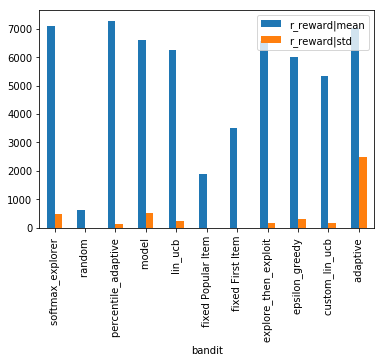

In [9]:
df_all[['r_reward|mean', 'r_reward|std']].plot(kind='bar')

In [10]:
df_all.to_csv("output/tmp/stats.csv")

## Plot

In [11]:

removed           = df_all.loc[['model ', 'fixed First Item']]['model|first'].values

input_legend      = ['bandit_policy', 'observation']
input_iteraction  = [p.split("/")[-1] for p in df_all['model|first'] if p not in removed]
sample_size       = 100000
window_size       = 1000 

st.set_option("client.displayEnabled", False)

metrics           = load_all_iteraction_metrics(input_iteraction, sample_size)
params            = load_iteractions_params2(input_iteraction)

df_metrics_reward = metrics.groupby("iteraction").agg({'reward': ['mean', 'sum']}).reset_index().sort_values([('reward', 'sum')], ascending=False)

df  = metrics.merge(params, on=['iteraction'], how='left')\
            .merge(metrics.groupby("iteraction")\
                    .agg({'reward': 'mean'})\
                    .rename(columns={'reward': 'sum_reward'})\
                    .reset_index(), 
              on=['iteraction'], how='left')\
            .reset_index()\
            .sort_values(['sum_reward', 'idx'], ascending=[False, True])


df.to_pickle('output/tmp/iteraction_df.pkl')
df.head()

/media/workspace/DeepFood/deep-reco-gym/tools/eval_viz/app.py:161: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,index,user,item,reward,index_env,idx,iteraction,activation_function,balance_fields,bandit_policy,...,seed,session_test_size,split_index,test_size,test_split_type,use_sampling_in_validation,val_size,val_split_type,weight_init,sum_reward
123200,123200,66,40,0.0,0,0,TrivagoLogisticModelInteraction_selu____adaptive_ec96120ad7,selu,[],adaptive,...,8,0.1,0,0.0,time,False,0.2,random,lecun_normal,0.500779
123201,123201,111,341,0.0,40,1,TrivagoLogisticModelInteraction_selu____adaptive_ec96120ad7,selu,[],adaptive,...,8,0.1,0,0.0,time,False,0.2,random,lecun_normal,0.500779
123202,123202,89,191,0.0,63,2,TrivagoLogisticModelInteraction_selu____adaptive_ec96120ad7,selu,[],adaptive,...,8,0.1,0,0.0,time,False,0.2,random,lecun_normal,0.500779
123203,123203,89,145,0.0,87,3,TrivagoLogisticModelInteraction_selu____adaptive_ec96120ad7,selu,[],adaptive,...,8,0.1,0,0.0,time,False,0.2,random,lecun_normal,0.500779
123204,123204,89,33,0.0,112,4,TrivagoLogisticModelInteraction_selu____adaptive_ec96120ad7,selu,[],adaptive,...,8,0.1,0,0.0,time,False,0.2,random,lecun_normal,0.500779


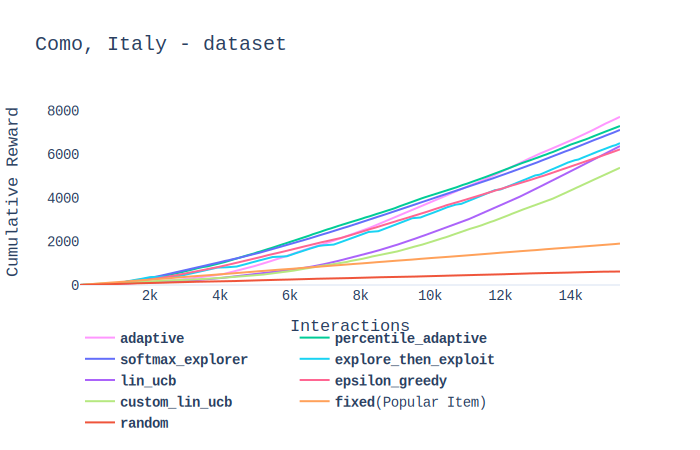

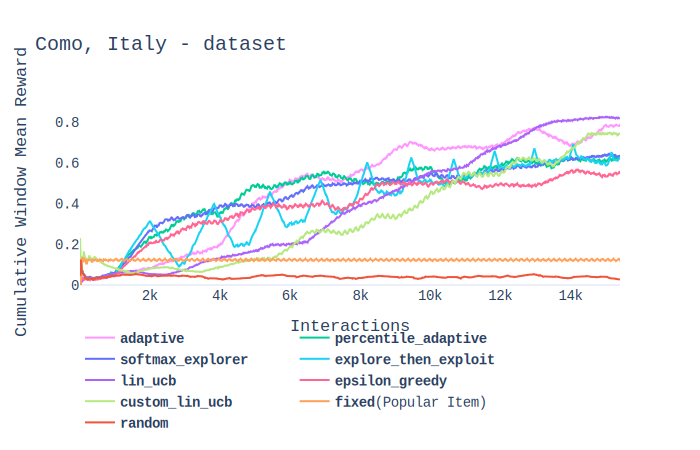

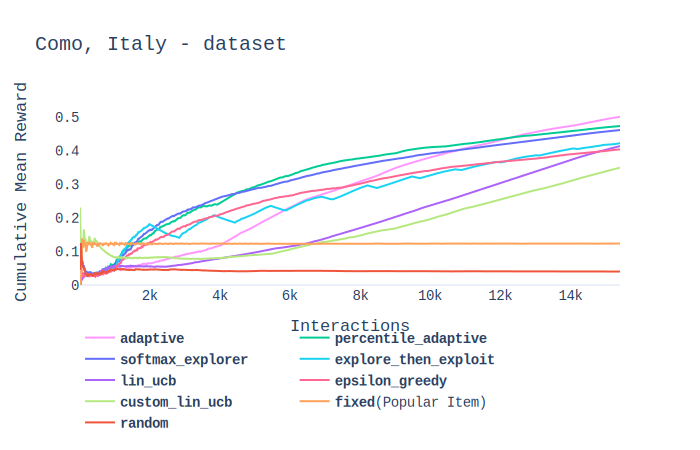

In [12]:
df = pd.read_pickle('output/tmp/iteraction_df.pkl')

# GERAL
for input_metrics in ['Cumulative Reward', 'Cumulative Window Mean Reward', 'Cumulative Mean Reward']:
    #input_metrics = 'Cumulative Mean Reward'
    fig = plot_line_iteraction(df, 'reward', 
                          title=input_metrics, 
                          legend=input_legend,
                          yrange=[0, 0.4], 
                          line_dict=get_colors(input_iteraction),
                          window=window_size,
                          cum=(input_metrics == 'Cumulative Reward'), 
                          mean=(input_metrics == 'Cumulative Mean Reward'),
                          roll=(input_metrics == 'Cumulative Window Mean Reward'))
    fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, title="{} - dataset".format(city))
    fig.update_layout(font={'family': 'Courier New, monospace', 'size': 14}, height=550)
    fig.show(renderer="svg")

    fig.write_image("output/tmp/iteraction_{}.eps".format(input_metrics.replace(" ", "_"))) #, width=1024, height=600, scale=2

## Recsys Metrics

In [11]:
from app import load_data_metrics, load_eval_params, filter_df, fetch_results_path
from plot import plot_bar

RECSYS_METRICS = [
  "count",
  "mean_average_precision",
  "precision_at_1",
  "ndcg_at_5",
  "ndcg_at_10",
  "ndcg_at_15",
  "ndcg_at_20",
  "ndcg_at_50",
  "coverage_at_5",
  "coverage_at_10",
  "coverage_at_15",
  "coverage_at_20",
  "coverage_at_50",
  "personalization_at_5",
  "personalization_at_10",
  "personalization_at_15",
  "personalization_at_20",
  "personalization_at_50",
  "IPS",
  "CIPS",
  "SNIPS",
  "DirectEstimator",
  "DoublyRobust"]


input_metrics = [
  "precision_at_1",
  "ndcg_at_5",
  "IPS",
  "DoublyRobust"
]

In [14]:
input_models_eval = fetch_results_path().keys()
input_params      = []
input_models_eval

dict_keys(['TrivagoLogisticModelInteraction_selu____model_828c2e71ff_57160a4dda_ps_per_logistic_regression_of_pos_item_idx_and_item_ps', 'TrivagoLogisticModelInteraction_selu____lin_ucb_f9bf3a6cc9_09a9da5d43_ps_per_logistic_regression_of_pos_item_idx_and_item_ps', 'TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'])

In [15]:
data_metrics       = load_data_metrics()
data_params        = load_eval_params()

df_metrics        = filter_df(data_metrics, input_models_eval, input_metrics, "")
df_eval_params    = filter_df(data_params, input_models_eval, input_params).transpose()

In [16]:
confidence_metrics = data_metrics[[c for c in data_metrics.columns if "_C" in c]]
for c in input_metrics:
    c_column = c+"_C" 
    confidence_metrics[c_column] = data_metrics[c_column] if c_column in data_metrics else None
confidence_metrics = confidence_metrics[[c+"_C" for c in input_metrics]]

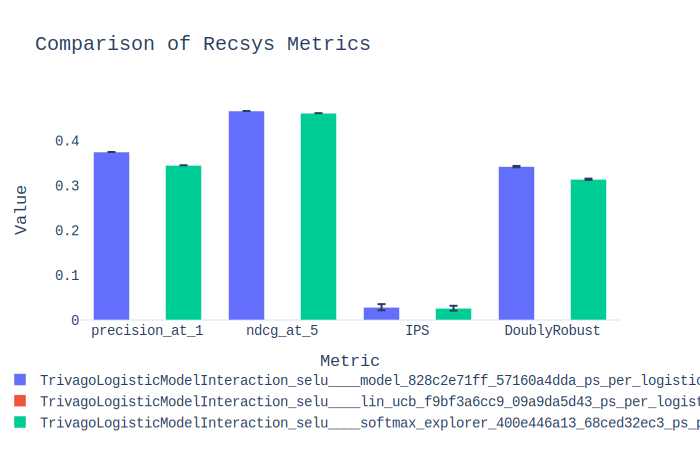

In [18]:
fig = plot_bar(df_metrics, confidence = confidence_metrics, title="Comparison of Recsys Metrics")

fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False)
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 14}, height=550)
fig.show(renderer="svg")

fig.write_image("output/tmp/metrics/recsys_rank.eps")

In [19]:
df_metrics

,precision_at_1,ndcg_at_5,IPS,DoublyRobust
path,,,,
TrivagoLogisticModelInteraction_selu____model_828c2e71ff_57160a4dda_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,0.374698,0.466151,0.028486,0.342096
TrivagoLogisticModelInteraction_selu____lin_ucb_f9bf3a6cc9_09a9da5d43_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,NaN,NaN,NaN,NaN
TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,0.345144,0.461348,0.026271,0.313925


## Fainess

In [27]:
from app import load_fairness_metrics, load_fairness_df
#from plot import plot_fairness_mistreatment
from app import load_data_metrics, load_eval_params, filter_df, fetch_results_path

TEMPLATE = 'plotly_white' #simple_white

def plot_fairness_mistreatment(df, metric, title=""):
    data = []

    data.append(go.Bar(y=df.index, x=df[metric], orientation='h',
                    error_x= dict(type='data', array=df[metric+"_C"]) if metric+"_C" in df.columns else {}  ,
                    marker={'color': list(range(len(df.index))), 
                            'colorscale': 'Tealgrn'})) #Plotly3

    fig = go.Figure(data=data)
    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    xaxis_title=metric, 
                    xaxis_range=(0, np.max([1, df[metric].max()])),
                    legend=dict(y=-0.2), title=title)
    #fig.update_traces(texttemplate='%{x:.2f}', textposition='outside')

    fig.update_layout(shapes=[
      dict(
        type= 'line',
        line=dict(
            width=1,
            dash="dot",
        ),        
        yref='paper', y0= 0, y1= 1,
        xref='x', x0= df[metric].mean(), x1= df[metric].mean()
      )
    ])

    st.plotly_chart(fig)

    return fig

### current_filters_sort_by_price

In [102]:

input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
input_features    = 'current_filters_sort_by_price'
input_metrics     = 'true_positive_rate'


In [103]:
def plot_fairness_metrics(input_models_eval, input_features, input_metrics, sub_map = None):
    df_all_metrics    = load_fairness_metrics().loc[input_models_eval]
    df_instances      = load_fairness_df().loc[input_models_eval]
    df_all_metric_filter = df_all_metrics[df_all_metrics.sub_key.isin([input_features])]

    columns         = list(np.unique(['sub_key', 'sub', 'feature', 'total_class', 'total_individuals'] + [input_metrics]))
    if input_metrics+"_C" in df_all_metrics.columns:
        columns.append(input_metrics+"_C")

    df_metrics      = filter_df(df_all_metrics, input_models_eval, columns, 'sub')

    df_metrics      = df_metrics[df_metrics.sub_key.isin([input_features])]
    if sub_map != None:
        df_metrics['sub'] = df_metrics['sub'].map(sub_map)
    
    df_metrics      = df_metrics.sort_values("feature").set_index("sub")
    df_metrics      = df_metrics.sort_values(input_metrics)
    df_metrics
    
    fig = plot_fairness_mistreatment(df_metrics, input_metrics, 
                      title="Disparate Mistreatment: "+input_features)

    fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, yaxis_title=input_features)
    fig.update_layout(font={'family': 'Courier New, monospace', 'size': 14}, height=550)

    
    df_total     = df_metrics[['total_class', 'total_individuals']]
    df_total_sum = df_total.sum(numeric_only=True)
    df_percent   = df_total/df_total_sum
    df_total     = df_total.apply(lambda row: ["{} ({:.2f} %)".format(i, p*100) for i,p in zip(row, df_percent[row.name])])
    df_total.loc['total'] = df_total_sum
    df_total.head(10)    
    
    return fig, df_metrics, df_total

In [104]:
fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics,
                                                 sub_map = {'1.0': 'True', '0.0': 'False'})

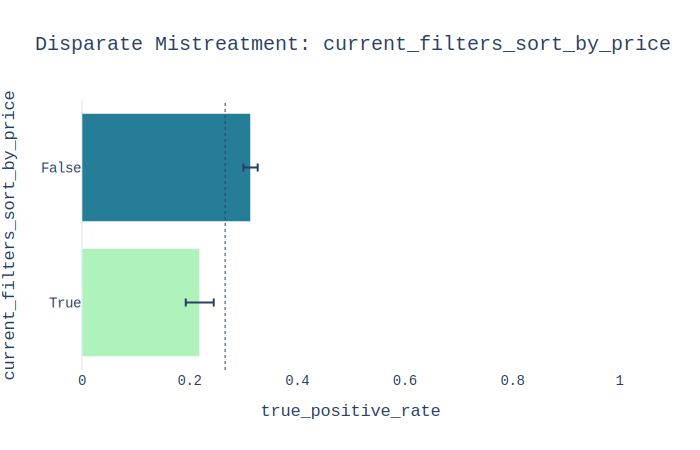

In [105]:
fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/recsys_fairnes_{}.eps".format(input_features))    

In [106]:
df_metrics.head()

,feature,sub_key,total_class,total_individuals,true_positive_rate,true_positive_rate_C
sub,,,,,,
True,current_filters_sort_by_price.1.0,current_filters_sort_by_price,1018,1303,0.218856,0.026016
False,current_filters_sort_by_price.0.0,current_filters_sort_by_price,3013,11115,0.313278,0.013276


In [107]:
df_total.head()

,total_class,total_individuals
sub,,
True,1018 (25.25 %),1303 (10.49 %)
False,3013 (74.75 %),11115 (89.51 %)
total,4031,12418


### current_filters_sort_by_price

In [108]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
input_features    = 'city_idx'
input_metrics     = 'true_positive_rate'

In [109]:
sub_map = {'0': "Boston, USA",
            '1': "Como, Italy",
            '2': "Chicago, USA",
            '3': "Lausanne, Switzerland",
            '4': "Dublin, Ireland",
            '5': "Rio de Janeiro, Brazil",
            '6': "Barcelona, Spain",
            '7': "Copenhagen, Denmark",
            '8': "Vienna, Austria",
            '9': "New York, USA",
            '10': "Hong Kong, Hong Kong",
            '11': "Vancouver, Canada"}



fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics,
                                                 sub_map = sub_map)

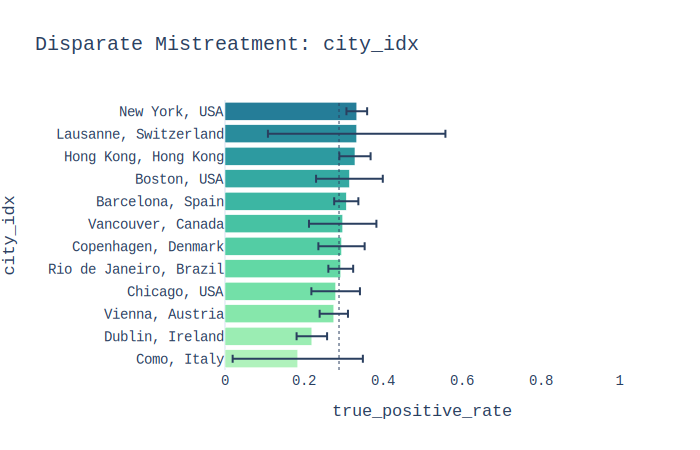

In [110]:
fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/recsys_fairnes_{}.eps".format(input_features))    

In [111]:
df_metrics.head(50)

,feature,sub_key,total_class,total_individuals,true_positive_rate,true_positive_rate_C
sub,,,,,,
"Como, Italy",city_idx.1,city_idx,28,30,0.184211,0.164835
"Dublin, Ireland",city_idx.4,city_idx,270,1035,0.219852,0.038611
"Vienna, Austria",city_idx.8,city_idx,361,1282,0.275460,0.035869
"Chicago, USA",city_idx.2,city_idx,146,375,0.280169,0.061477
"Rio de Janeiro, Brazil",city_idx.5,city_idx,572,2114,0.293080,0.031405
"Copenhagen, Denmark",city_idx.7,city_idx,120,572,0.294983,0.058567
"Vancouver, Canada",city_idx.11,city_idx,83,214,0.297954,0.085353
"Barcelona, Spain",city_idx.6,city_idx,624,1652,0.307026,0.030600
"Boston, USA",city_idx.0,city_idx,97,198,0.314981,0.084484


In [112]:
df_total.head()

,total_class,total_individuals
sub,,
"Como, Italy",28 (0.84 %),30 (0.24 %)
"Dublin, Ireland",270 (8.14 %),1035 (8.33 %)
"Vienna, Austria",361 (10.88 %),1282 (10.32 %)
"Chicago, USA",146 (4.40 %),375 (3.02 %)
"Rio de Janeiro, Brazil",572 (17.24 %),2114 (17.02 %)
